In [1]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd



Mounted at /content/drive


In [2]:
#Import data

sheet_url = "https://docs.google.com/spreadsheets/d/1_LWErSQCdNm2O1r7ZxszgblbXNbrIDu3eBBDvkaJ_C0/edit?gid=1349519076"
sheet_id = sheet_url.split("/d/")[1].split("/")[0]
csv_export_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid=1349519076"
df = pd.read_csv(csv_export_url)
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


## Remove contents that have user name "@..."

In [3]:
# remove user name
df = pd.DataFrame(df)

def content_reformat(text):
  tokens = text.split()
  if tokens and tokens[0].startswith('@'):
      tokens = tokens[1:]
  return ' '.join(tokens)

df['content'] = df['content'].apply(content_reformat)
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,i know i was listenin to bad habit earlier and...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin on...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,We want to trade with someone who has Houston ...


## Convert sentiment into categorical variables


In [4]:
df_convert = df.copy()
# categorical labels
df_convert['sentiment_label'] = df_convert['sentiment'].astype('category').cat.codes
# map to original content for refernce
map_label = dict(enumerate(df_convert['sentiment'].astype('category').cat.categories))
df_convert['sentiment'] = df_convert['sentiment_label'].map(map_label)
df_convert.head()


,tweet_id,sentiment,content,sentiment_label
0,1956967341,empty,i know i was listenin to bad habit earlier and...,2
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin on...,10
2,1956967696,sadness,Funeral ceremony...gloomy friday...,10
3,1956967789,enthusiasm,wants to hang out with friends SOON!,3
4,1956968416,neutral,We want to trade with someone who has Houston ...,8


## Visualizing Sentiment Mapping

In [5]:
map_table = pd.DataFrame(list(map_label.items()), columns=['sentiment_label', 'sentiment'])
map_table

,sentiment_label,sentiment
0,0,anger
1,1,boredom
2,2,empty
3,3,enthusiasm
4,4,fun
5,5,happiness
6,6,hate
7,7,love
8,8,neutral
9,9,relief


## BERT Implementation


In [6]:
import torch, math, random, itertools
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [7]:
seed = 21
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
df_convert['content'][1]

'Layin n bed with a headache ughhhh...waitin on your call...'

## BERT implementation

| **Token** | **Purpose** |
|:----------:|-------------|
| `[CLS]` | The first token is always classification. |
| `[SEP]` | Separates two sentences. |
| `[END]` | Ends the sentence. |
| `[PAD]` | Used to pad the sentence to equal length. |
| `[MASK]` | Used to create a mask by replacing the original word. |

In [9]:
#  Input: list, Output:
sentence = df_convert['content'].tolist()
label = df_convert['sentiment_label'].tolist()
len(sentence), len(label)
# sentence[0]
sentence[2], label[2]

('Funeral ceremony...gloomy friday...', 10)

In [10]:
# train-test split
from sklearn.model_selection import train_test_split

## trim half dataset for efficiency purpose

In [11]:
sentence_cut, _, label_cut, _ = train_test_split(
    sentence, label, train_size = 0.5, shuffle = True, random_state = 21)
train_input, test_input, train_labels, test_labels = train_test_split(
    sentence_cut, label_cut, test_size = 0.2, random_state = 21)

In [12]:
# tokenization
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenizer_train = tokenizer(
    train_input,
    padding = True,
    truncation = True,
    return_tensors = 'pt',
    max_length = 128
)
tokenizer_test = tokenizer(
    test_input,
    padding = True,
    truncation = True,
    return_tensors = 'pt',
    max_length = 128
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:
# pip install --upgrade transformers

In [14]:
from datasets import Dataset

In [15]:
train_labels_tensor = torch.tensor(train_labels)
test_labels_tensor = torch.tensor(test_labels)

In [16]:
# BERT dataset
bert_train_ds = Dataset.from_dict({
    'input_ids': tokenizer_train['input_ids'],
    'attention_mask': tokenizer_train['attention_mask'],
    'labels': train_labels
})

bert_test_ds = Dataset.from_dict({
    'input_ids': tokenizer_test['input_ids'],
    'attention_mask': tokenizer_test['attention_mask'],
    'labels': test_labels
})
# stick with paper parameters 8, random seed 21, epoch 10, learning rate, 5e-5
train_loader = DataLoader(bert_train_ds, batch_size = 8, shuffle = True)
test_loader = DataLoader(bert_test_ds, batch_size = 8, shuffle = True)

## Visualize an example

In [17]:
batch = next(iter(train_loader))
input_ids_batch = batch['input_ids']
attention_mask_batch = batch['attention_mask']
labels_batch = batch['labels']

# Convert token IDs back to text
first_sentence_tokens = tokenizer.convert_ids_to_tokens(input_ids_batch[0])
first_sentence_text = tokenizer.decode(input_ids_batch[0], skip_special_tokens=True)

print("Token IDs:", input_ids_batch[0])
print("Tokens:", first_sentence_tokens)
print("Decoded text:", first_sentence_text)
print("Label:", labels_batch[0].item(), "->", map_label[labels_batch[0].item()])


Token IDs: tensor([101, 101, 101, 101, 101, 101, 101, 101])
Tokens: ['[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]']
Decoded text: 
Label: 5 -> happiness


## Training

In [18]:
num_labels = len(map_label)
bert_model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = num_labels)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

def performance_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [20]:
training_args = TrainingArguments(
    output_dir = './results',
    #overwrite_output_dir = True,
    learning_rate = 5e-5,
    eval_strategy="epoch",
    seed = seed,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 2,
    logging_dir = './logs',
    report_to = []
)

trainer = Trainer(
    model = bert_model,
    args = training_args,
    train_dataset = bert_train_ds,
    eval_dataset = bert_test_ds,
    tokenizer = tokenizer,
    ## add this for F1, Precision and Reall
    compute_metrics = performance_metrics

)

train_output = trainer.train()
# Print training loss
print(f"Training loss: {train_output.training_loss}")
# Also evaluate to see eval loss after training
eval_metrics = trainer.evaluate()
print("Eval metrics:", eval_metrics)

/tmp/ipython-input-2784079182.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.832000,1.784700,0.393500,0.352777,0.342142,0.393500
2,1.536900,1.851908,0.393000,0.364373,0.351768,0.393000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training loss: 1.7280844116210938


Eval metrics: {'eval_loss': 1.8519079685211182, 'eval_accuracy': 0.393, 'eval_f1': 0.36437312870927574, 'eval_precision': 0.35176811725833235, 'eval_recall': 0.393, 'eval_runtime': 14.404, 'eval_samples_per_second': 277.7, 'eval_steps_per_second': 34.713, 'epoch': 2.0}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Confusion matrix and Plot

In [25]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[  0   0   0   0   0   0   0   1   2   0   0   0   5]
 [  0   0   0   0   0   1   1   0   5   0   2   0   6]
 [  0   0   0   0   0   6   3   0  32   0   5   0  21]
 [  0   0   0   0   0  17   0   2  17   4   2   0   9]
 [  0   0   0   0   1  76   5  17  44   0  10   7  19]
 [  0   0   0   0  13 257   7  75  90  13  15   6  54]
 [  0   0   0   0   0   3  28   0  15   0  18   4  44]
 [  0   0   0   0   4  93   5 177  49   5  30   3  40]
 [  0   0   0   0   4  97  12  36 490   9  54  12 153]
 [  0   0   0   0   0  52   2  15  42  13   8   1  36]
 [  0   0   0   0   0  28  20  25  70   5 185   4 203]
 [  0   0   0   0   0  44   6  15  59   2  21  10  65]
 [  0   0   0   0   1  65  37  18 144   8 133  17 411]]


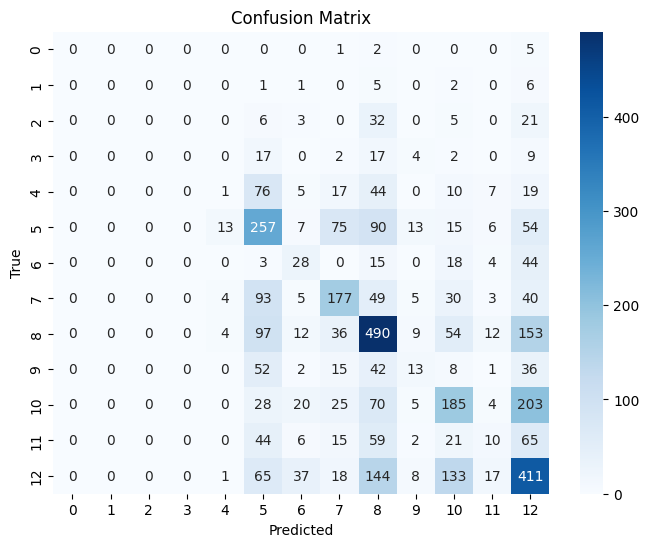

In [26]:
# get predictions
pred_output = trainer.predict(bert_test_ds)
# raw logit:
pred_prob = pred_output.predictions
# predicted labels
pred_label = pred_output.label_ids
prediction =np.argmax(pred_prob, axis = -1)

#confusion matrix
cm = confusion_matrix(test_labels, prediction)
print(cm)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [27]:
cls_report = classification_report(pred_label, prediction, target_names=map_label.values())
print(cls_report)

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         8
     boredom       0.00      0.00      0.00        15
       empty       0.00      0.00      0.00        67
  enthusiasm       0.00      0.00      0.00        51
         fun       0.04      0.01      0.01       179
   happiness       0.35      0.48      0.41       530
        hate       0.22      0.25      0.24       112
        love       0.46      0.44      0.45       406
     neutral       0.46      0.57      0.51       867
      relief       0.22      0.08      0.11       169
     sadness       0.38      0.34      0.36       540
    surprise       0.16      0.05      0.07       222
       worry       0.39      0.49      0.43       834

    accuracy                           0.39      4000
   macro avg       0.21      0.21      0.20      4000
weighted avg       0.35      0.39      0.36      4000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Visualize outputs

In [34]:
# randomly select 10 sentence from test set
idx = random.sample(range(len(bert_test_ds)), 10)

# store results
results = []

for i in idx:
  # extract individual components from the dataset
    item = bert_test_ds[i]
    input_ids = item['input_ids']
    attention_mask = item['attention_mask']
    label = item['labels']
  # convert to sentence readable by human
    sentence = tokenizer.decode(input_ids, skip_special_tokens=True)
  # input to BERT model
    inputs = {
        'input_ids': torch.tensor([input_ids]).to(trainer.model.device),
        'attention_mask': torch.tensor([attention_mask]).to(trainer.model.device)
    }
    # eval mode
    bert_model.eval()

    with torch.no_grad():
      # **inputs get the input pair
        logits = bert_model(**inputs).logits
        pred_label = torch.argmax(logits, dim=-1).item()

    # store variables for result display
    results.append({
        "sentence": sentence,
        "true_label": label,
        "pred_label": pred_label
    })


# Display
for r in results:
    print(f"Sentence: {r['sentence']}")
    print(f"True Label: {r['true_label']}, Predicted: {r['pred_label']}")
    print("-"*50)

Sentence: i knew my mom loved flowers and she loves the rieger begonia so... hanging basket seemed perfect
True Label: 7, Predicted: 7
--------------------------------------------------
Sentence: hi simon, let me know when it ' s done
True Label: 8, Predicted: 8
--------------------------------------------------
Sentence: it ' s not a reg gig yet, but hopefully it will be! haven ' t done massage in a while actually
True Label: 12, Predicted: 9
--------------------------------------------------
Sentence: apparently so! i ' m falling apart in front of my eyes
True Label: 12, Predicted: 12
--------------------------------------------------
Sentence: i still have my lights still up you think he can do mine too?
True Label: 8, Predicted: 8
--------------------------------------------------
Sentence: my newsreader is filling up with blogs yay! keep pm ' ing me your blog sites. i love reading them!
True Label: 8, Predicted: 7
--------------------------------------------------
Sentence: i can 

In [32]:
print(bert_test_ds[0])


{'input_ids': [101, 6517, 2138, 1037, 3712, 15909, 3298, 1005, 1055, 2047, 2774, 2123, 1005, 1056, 2614, 2004, 2204, 2004, 1045, 2018, 5113, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 11}


## Trying with user defined input

In [49]:
def user_input_prediction():
  user_input = input("Enter a sentence:" )
  user_input_tokenized = tokenizer(
    user_input,
    return_tensors = 'pt',
    truncation = True,
    padding = True
    )
  user_inputs = {k: v.to(trainer.model.device) for k, v in user_input_tokenized.items()}
  bert_model.eval()

  with torch.no_grad():
    logits = bert_model(**user_inputs).logits

    pred_label = torch.argmax(logits, dim=-1).item()
  print(f"Sentence: {user_input}")
  print(f"Predicted label: {pred_label}")


In [50]:
user_input_prediction()

Enter a sentence:I am happy
Sentence: I am happy
Predicted label: 7


In [42]:
print(map_table)

    sentiment_label   sentiment
0                 0       anger
1                 1     boredom
2                 2       empty
3                 3  enthusiasm
4                 4         fun
5                 5   happiness
6                 6        hate
7                 7        love
8                 8     neutral
9                 9      relief
10               10     sadness
11               11    surprise
12               12       worry
